In [1]:
# Import required packages
import pandas as pd
import altair as alt
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
# Install required fairlearn packages
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate,count, selection_rate
from fairlearn.datasets import fetch_adult
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlearn.reductions import DemographicParity

# Exploratory Data Analysis

## Data Cleaning

In [3]:
# Save dataset to a variable
df = pd.read_csv('techmentalhealth.csv')

# Drop 'Timestamp' and 'comments' columns
df = df.drop(['Timestamp', 'comments'], axis=1)

In [4]:
# List the unique values in the 'gender' column
df['Gender'].unique()

array(['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile',
       'Trans-female', 'Cis Female', 'F', 'something kinda male?',
       'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they',
       'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby',
       'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender',
       'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous',
       'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)',
       'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you',
       'Malr', 'p', 'femail', 'Cis Man',
       'ostensibly male, unsure what that really means'], dtype=object)

In [5]:
# Define a function to classifiy responses to gender categories
def categorize_gender(g):
    if g in ['male', 'Male', 'M', 'm', 'Male-ish', 'Cis Male', 'Mal',
             'Make', 'Guy (-ish) ^_^', 'Male ', 'msle', 'Mail', 'cis male', 'Malr', 'Cis Man']:
        gender = "Male"
    elif g in ['Female', 'female', 'Trans-female', 'Cis Female', 'F',
               'f', 'woman', 'Female ', 'cis-female/femme', 'Trans woman',
               'Female (trans)', 'Female (cis)', 'Woman', 'femail']:
        gender = "Female"
    else:
        gender = "Non-binary"
    return gender

In [6]:
# Apply the function to the 'Gender' column
df['Gender'] = df['Gender'].apply(categorize_gender)

# List the unique values in the 'Gender' column
df['Gender'].unique()

array(['Female', 'Male', 'Non-binary'], dtype=object)

In [7]:
# Divide the dataset based on whether the observation is from the United States or not
df_us = df[df['Country'] == 'United States']
df_other = df[df['Country'] != 'United States']

# Drop the 'Country' column from the US dataset
df_us = df_us.drop(['Country'], axis=1)

# Drop the 'state' column from the non-US dataset
df_other = df_other.drop(['state'], axis=1)

In [8]:
# Designate positive and negative labels to target column
labels = {'Yes': 1, 'No': 0}
df_us['treatment'] = df_us['treatment'].replace(labels)
df_other['treatment'] = df_other['treatment'].replace(labels)

In [9]:
# Split data into train and test sets
train_df_us, test_df_us = train_test_split(df_us, test_size=0.2, random_state=123)
train_df_other, test_df_other = train_test_split(df_other, test_size=0.2, random_state=123)

## Data Exploration

In [10]:
# Look at first 5 rows of the US training dataset
train_df_us.head(5)

,Age,Gender,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
410,33,Male,OH,No,Yes,1,Often,More than 1000,Yes,Yes,...,Don't know,Somewhat easy,Yes,No,No,No,No,No,No,No
248,32,Male,NC,No,Yes,1,Sometimes,1-5,Yes,Yes,...,Don't know,Don't know,Maybe,No,Yes,Yes,No,Yes,Don't know,No
374,21,Female,CA,No,Yes,1,Rarely,26-100,No,Yes,...,Don't know,Somewhat easy,Yes,No,Some of them,No,No,Yes,Don't know,No
92,34,Male,OH,No,No,0,NaN,26-100,No,Yes,...,Don't know,Somewhat easy,Maybe,No,Some of them,No,No,Maybe,Don't know,No
480,23,Male,VA,No,No,0,Never,26-100,No,No,...,Don't know,Don't know,No,No,Yes,Yes,Maybe,Yes,Yes,No


In [11]:
# Look at first 5 rows of the non-US training dataset
train_df_other.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
440,26,Male,United Kingdom,No,Yes,0,Sometimes,6-25,No,Yes,...,Don't know,Don't know,Maybe,Maybe,No,No,No,Maybe,No,No
901,43,Male,United Kingdom,No,Yes,1,Rarely,26-100,No,Yes,...,Don't know,Very difficult,Yes,Yes,Some of them,No,No,No,No,Yes
1200,28,Male,Australia,No,No,1,Often,100-500,Yes,Yes,...,Don't know,Don't know,Yes,No,No,No,No,Maybe,No,No
1144,23,Male,Israel,No,No,0,Never,More than 1000,No,No,...,Yes,Somewhat difficult,No,No,Yes,Yes,No,Yes,Yes,No
749,19,Male,Canada,No,No,1,Sometimes,26-100,No,Yes,...,Don't know,Somewhat difficult,No,No,Some of them,Yes,No,Yes,Don't know,No


In [12]:
# Check for variable types and missing values in the US training dataset
train_df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 410 to 839
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        600 non-null    int64 
 1   Gender                     600 non-null    object
 2   state                      593 non-null    object
 3   self_employed              592 non-null    object
 4   family_history             600 non-null    object
 5   treatment                  600 non-null    int64 
 6   work_interfere             485 non-null    object
 7   no_employees               600 non-null    object
 8   remote_work                600 non-null    object
 9   tech_company               600 non-null    object
 10  benefits                   600 non-null    object
 11  care_options               600 non-null    object
 12  wellness_program           600 non-null    object
 13  seek_help                  600 non-null    object
 14  anonymit

In [13]:
# Check for variable types and missing values in the non-US training dataset
train_df_other.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 440 to 962
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        406 non-null    int64 
 1   Gender                     406 non-null    object
 2   Country                    406 non-null    object
 3   self_employed              400 non-null    object
 4   family_history             406 non-null    object
 5   treatment                  406 non-null    int64 
 6   work_interfere             312 non-null    object
 7   no_employees               406 non-null    object
 8   remote_work                406 non-null    object
 9   tech_company               406 non-null    object
 10  benefits                   406 non-null    object
 11  care_options               406 non-null    object
 12  wellness_program           406 non-null    object
 13  seek_help                  406 non-null    object
 14  anonymit

In [14]:
# Check number of unique values for each column in the US dataset
train_df_us.nunique()

Age                          47
Gender                        3
state                        45
self_employed                 2
family_history                2
treatment                     2
work_interfere                4
no_employees                  6
remote_work                   2
tech_company                  2
benefits                      3
care_options                  3
wellness_program              3
seek_help                     3
anonymity                     3
leave                         5
mental_health_consequence     3
phys_health_consequence       3
coworkers                     3
supervisor                    3
mental_health_interview       3
phys_health_interview         3
mental_vs_physical            3
obs_consequence               2
dtype: int64

In [15]:
# Check number of unique values for each column in the non-US dataset
train_df_other.nunique()

Age                          36
Gender                        3
Country                      41
self_employed                 2
family_history                2
treatment                     2
work_interfere                4
no_employees                  6
remote_work                   2
tech_company                  2
benefits                      3
care_options                  3
wellness_program              3
seek_help                     3
anonymity                     3
leave                         5
mental_health_consequence     3
phys_health_consequence       3
coworkers                     3
supervisor                    3
mental_health_interview       3
phys_health_interview         3
mental_vs_physical            3
obs_consequence               2
dtype: int64

In [16]:
# Check for classes in the target feature in the US dataset
train_df_us['treatment'].value_counts()

1    327
0    273
Name: treatment, dtype: int64

In [17]:
# Check for classes in the target feature in the non-US dataset
train_df_other['treatment'].value_counts()

0    223
1    183
Name: treatment, dtype: int64

In [18]:
# Drop the 'state' column from the US dataset
train_df_us_2 = train_df_us.drop(['state'], axis=1)

# Plot distributions of features in the US dataset based on target column
alt.Chart(train_df_us_2.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment:N')
).properties(
    height=200, width=80
).repeat(
    train_df_us_2.select_dtypes('object').columns.to_list(),
    columns=7
)

alt.RepeatChart(...)

In [19]:
# Save only the 'state' feature and treatment class in the US training data
train_df_us_3 = train_df_us[['state', 'treatment']]

# Plot distributions of features in the USA dataset based on target column
alt.Chart(train_df_us_3.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment:N')
).properties(
    height=200
).repeat(
    train_df_us_3.select_dtypes('object').columns.to_list(),
    columns=1
)

alt.RepeatChart(...)

In [20]:
# Drop the 'state' column from the non-US dataset
train_df_other_2 = train_df_other.drop(['Country'], axis=1)

# Plot distributions of features in the non-US dataset based on target column
alt.Chart(train_df_other_2.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment:N')
).properties(
    height=200
).repeat(
    train_df_other_2.select_dtypes('object').columns.to_list(),
    columns=7
)

alt.RepeatChart(...)

In [21]:
# Save only the 'Country' feature and treatment class in the non-US training data
train_df_other_3 = train_df_other[['Country', 'treatment']]

# Plot distributions of features in the non-US dataset based on target column
alt.Chart(train_df_other_3.sort_values('treatment')).mark_bar(opacity=0.6).encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()', stack=None),
    alt.Color('treatment:N')
).properties(
    height=200
).repeat(
    train_df_other_3.select_dtypes('object').columns.to_list(),
    columns=1
)

alt.RepeatChart(...)

# Method and Results

In [22]:
# Create target, feature, and sensitive data sets for US observations
X_train_us = train_df_us.drop(columns=['treatment', 'Gender'])
y_train_us = train_df_us['treatment']
A_train_us = train_df_us['Gender']

X_test_us = test_df_us.drop(columns=['treatment', 'Gender'])
y_test_us = test_df_us['treatment']
A_test_us = test_df_us['Gender']

In [23]:
# Create target, feature, and sensitive data sets for non-US observations
X_train_other = train_df_other.drop(columns=['treatment', 'Gender'])
y_train_other = train_df_other['treatment']
A_train_other = train_df_other['Gender']

X_test_other = test_df_other.drop(columns=['treatment', 'Gender'])
y_test_other = test_df_other['treatment']
A_test_other = test_df_other['Gender']

## Feature Pre-processing

In [24]:
# Save numeric features in a list
numeric_features = ['Age']

# Save categorical features from the US dataset in a list
categorical_features_us = ['state','work_interfere', 'no_employees',
                        'benefits', 'care_options', 'wellness_program',
                        'seek_help', 'anonymity', 'leave',
                        'mental_health_consequence', 'phys_health_consequence', 'coworkers',
                        'supervisor', 'mental_health_interview', 'phys_health_interview',
                        'mental_vs_physical']

# Save categorical features from the non-US dataset in a list
categorical_features_other = ['Country','work_interfere', 'no_employees',
                        'benefits', 'care_options', 'wellness_program',
                        'seek_help', 'anonymity', 'leave',
                        'mental_health_consequence', 'phys_health_consequence', 'coworkers',
                        'supervisor', 'mental_health_interview', 'phys_health_interview',
                        'mental_vs_physical']

# Save binary features in a list
binary_features = ['self_employed', 'family_history', 'remote_work',
                   'tech_company', 'obs_consequence']

In [25]:
# Make a pipeline to preprocess numerical features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [26]:
# Make a pipeline to preprocess categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown='ignore')
)

In [27]:
# Make a pipeline to preprocess binary features
binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [28]:
# Create a column transformer to apply transformations to features in the US dataset
preprocessor_us = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features_us),
    (binary_transformer, binary_features)
)

# Create a column transformer to apply transformations to features in the non-US dataset
preprocessor_other = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features_other),
    (binary_transformer, binary_features)
)

In [29]:
# Fit the preprocessors to the training data
X_train_preprocessed_us = preprocessor_us.fit_transform(X_train_us)
X_train_preprocessed_other = preprocessor_us.fit_transform(X_train_us)

# Count the number of features in the preprocessed datasets
print(X_train_preprocessed_us.shape[1:])
print(X_train_preprocessed_other.shape[1:])

(106,)
(106,)


In [30]:
# Save the 30% of the number of features for feature selection
feature_number_select = int(106*0.3)

## Dummy Model

### USA

In [31]:
# Initiate a dummy classifier
dummy_us = DummyClassifier(strategy='most_frequent')

# Fit the dummy model on the whole USA training set
dummy_us.fit(X_train_us, y_train_us)

# Obtain the cross validation recall scores
dummy_cv_score_us = cross_validate(dummy_us, X_train_us, y_train_us, cv=3, return_train_score=True, scoring='f1')
dummy_cv_score_us_df = pd.DataFrame(dummy_cv_score_us)
print(dummy_cv_score_us_df.mean())

fit_time       0.000305
score_time     0.000754
test_score     0.705502
train_score    0.705502
dtype: float64


In [32]:
# Score the dummy classifier on the USA training data
dummy_train_score_us = dummy_us.score(X_train_us, y_train_us)
print("Dummy training score: %s." % round(dummy_train_score_us, 3))

# Score the dummy classifier on the USA test data
dummy_test_score_us = dummy_us.score(X_test_us, y_test_us)
print("Dummy test score: %s." % round(dummy_test_score_us, 3))

Dummy training score: 0.545.
Dummy test score: 0.55.


### Non-USA

In [33]:
# Initiate a dummy classifier
dummy_other = DummyClassifier(strategy='most_frequent')

# Fit the dummy model on the whole non-USA training set
dummy_other.fit(X_train_other, y_train_other)

# Obtain the cross validation recall scores
dummy_cv_score_other = cross_validate(dummy_other, X_train_other, y_train_other, cv=3, return_train_score=True, scoring='f1')
dummy_cv_score_other_df = pd.DataFrame(dummy_cv_score_other)
print(dummy_cv_score_other_df.mean())

fit_time       0.000327
score_time     0.000596
test_score     0.000000
train_score    0.000000
dtype: float64


In [34]:
# Score the dummy classifier on the non-USA training data
dummy_train_score_other = dummy_other.score(X_train_other, y_train_other)
print("Dummy training score: %s." % round(dummy_train_score_other, 3))

# Score the dummy classifier on the non-USA test data
dummy_test_score_other = dummy_other.score(X_test_other, y_test_other)
print("Dummy test score: %s." % round(dummy_test_score_other, 3))

Dummy training score: 0.549.
Dummy test score: 0.569.


## Hyperparameter Tuning, Feature Selection, and Fairness Optimization

### Decision Tree Classifier

#### USA

In [35]:
# Initiate a decision tree classifier pipeline
dt_pipe_us = make_pipeline(
    preprocessor_us,
    DecisionTreeClassifier())

In [36]:
# Set hyperparameters for cross validation
dt_param_grid = {
    "decisiontreeclassifier__max_depth": [5, 7, 9, 11],
    "decisiontreeclassifier__min_impurity_decrease": [0.001, 0.01, 0.1, 0.5]
}

# Perform cross validation with grid search
dt_gs_us = GridSearchCV(dt_pipe_us, dt_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
dt_gs_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 7, 9, 11],
                         'decisiontreeclassifier__min_impurity_decrease': [0.001,
                                                                           0.01,
                                                                           0.1,
                                                                           0.5]},
             return_train_score=True, scoring='f1')

In [37]:
# Obtain the best parameters and cross validation scores
dt_gs_param_us = dt_gs_us.best_params_
dt_gs_score_us = dt_gs_us.best_score_
print("Best Parameters for the Decision Tree Classifier:", dt_gs_param_us)
print("Best Cross Validation Score for the Decision Tree Classifier:", dt_gs_score_us)

Best Parameters for the Decision Tree Classifier: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_impurity_decrease': 0.1}
Best Cross Validation Score for the Decision Tree Classifier: 0.8741780124108548


#### Non-USA

In [38]:
# Initiate a decision tree classifier pipeline
dt_pipe_other = make_pipeline(
    preprocessor_other,
    DecisionTreeClassifier())

In [39]:
# Set hyperparameters for cross validation
dt_param_grid = {
    "decisiontreeclassifier__max_depth": [5, 7, 9, 11],
    "decisiontreeclassifier__min_impurity_decrease": [0.001, 0.01, 0.1, 0.5]
}

# Perform cross validation with grid search
dt_gs_other = GridSearchCV(dt_pipe_other, dt_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
dt_gs_other.fit(X_train_other, y_train_other)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [5, 7, 9, 11],
                         'decisiontreeclassifier__min_impurity_decrease': [0.001,
                                                                           0.01,
                                                                           0.1,
                                                                           0.5]},
             return_train_score=True, scoring='f1')

In [40]:
# Obtain the best parameters and cross validation scores
dt_gs_param_other = dt_gs_other.best_params_
dt_gs_score_other = dt_gs_other.best_score_
print("Best Parameters for the Decision Tree Classifier:", dt_gs_param_other)
print("Best Cross Validation Score for the Decision Tree Classifier:", dt_gs_score_other)

Best Parameters for the Decision Tree Classifier: {'decisiontreeclassifier__max_depth': 7, 'decisiontreeclassifier__min_impurity_decrease': 0.01}
Best Cross Validation Score for the Decision Tree Classifier: 0.7778613199665831


### kNN Model

#### USA

In [41]:
# Initiate a kNN classifier pipeline
knn_pipe_us = make_pipeline(
    preprocessor_us,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    KNeighborsClassifier())

In [42]:
# Set hyperparameters for cross validation
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]
}

# Perform cross validation with grid search
knn_gs_us = GridSearchCV(knn_pipe_us, knn_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
knn_gs_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]},
             return_train_score=True, scoring='f1')

In [43]:
# Obtain the best parameters and cross validation scores
knn_gs_param_us = knn_gs_us.best_params_
knn_gs_score_us = knn_gs_us.best_score_
print("Best Parameters for the kNN Classifier:", knn_gs_param_us)
print("Best Cross Validation Score for the kNN Classifier:", knn_gs_score_us)

Best Parameters for the kNN Classifier: {'kneighborsclassifier__n_neighbors': 7}
Best Cross Validation Score for the kNN Classifier: 0.8461958794998443


#### Non-USA

In [44]:
# Initiate a kNN classifier pipeline
knn_pipe_other = make_pipeline(
    preprocessor_other,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    KNeighborsClassifier())

In [45]:
# Set hyperparameters for cross validation
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]
}

# Perform cross validation with grid search
knn_gs_other = GridSearchCV(knn_pipe_other, knn_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
knn_gs_other.fit(X_train_other, y_train_other)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9]},
             return_train_score=True, scoring='f1')

In [46]:
# Obtain the best parameters and cross validation scores
knn_gs_param_other = knn_gs_other.best_params_
knn_gs_score_other = knn_gs_other.best_score_
print("Best Parameters for the kNN Classifier:", knn_gs_param_other)
print("Best Cross Validation Score for the kNN Classifier:", knn_gs_score_other)

Best Parameters for the kNN Classifier: {'kneighborsclassifier__n_neighbors': 7}
Best Cross Validation Score for the kNN Classifier: 0.7195340501792113


### SVC Model

#### USA

In [47]:
# Initiate a SVC model
svc_pipe_us = make_pipeline(
    preprocessor_us,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    SVC(probability=True))  

In [48]:
# Set hyperparameters for cross validation
svc_param_grid = {
    "svc__gamma": [0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100]
}

# Perform cross validation with grid search
svc_gs_us = GridSearchCV(svc_pipe_us, svc_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
svc_gs_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1.0, 10, 100],
                         'svc__gamma': [0.1, 1.0, 10, 100]},
             return_train_score=True, scoring='f1')

In [49]:
# Obtain the best parameters and cross validation scores
svc_gs_param_us = svc_gs_us.best_params_
svc_gs_score_us = svc_gs_us.best_score_
print("Best Parameters for the SVC model:", svc_gs_param_us)
print("Best Cross Validation Score for the SVC model:", svc_gs_score_us)

Best Parameters for the SVC model: {'svc__C': 1.0, 'svc__gamma': 0.1}
Best Cross Validation Score for the SVC model: 0.8741780124108548


#### Non-USA

In [50]:
# Initiate a SVC model
svc_pipe_other = make_pipeline(
    preprocessor_other,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    SVC(probability=True)) 

In [51]:
# Set hyperparameters for cross validation
svc_param_grid = {
    "svc__gamma": [0.1, 1.0, 10, 100],
    "svc__C": [0.1, 1.0, 10, 100]
}

# Perform cross validation with grid search
svc_gs_other = GridSearchCV(svc_pipe_other, svc_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
svc_gs_other.fit(X_train_other, y_train_other)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1.0, 10, 100],
                         'svc__gamma': [0.1, 1.0, 10, 100]},
             return_train_score=True, scoring='f1')

In [52]:
# Obtain the best parameters and cross validation scores
svc_gs_param_other = svc_gs_other.best_params_
svc_gs_score_other = svc_gs_other.best_score_
print("Best Parameters for the SVC model:", svc_gs_param_other)
print("Best Cross Validation Score for the SVC model:", svc_gs_score_other)

Best Parameters for the SVC model: {'svc__C': 1.0, 'svc__gamma': 0.1}
Best Cross Validation Score for the SVC model: 0.7989248839632471


### Logistic Regression

#### USA

In [53]:
# Initiate a logistic regression pipeline
log_pipe_us = make_pipeline(
    preprocessor_us,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    LogisticRegression(max_iter=1000)
)

In [54]:
# Set hyperparameters for cross validation
log_param_grid = {
    "rfecv__estimator__C": np.linspace(0.1, 100, 100)
}

# Perform cross validation with grid search
log_gs_us = GridSearchCV(log_pipe_us, log_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
log_gs_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
        72.75454545,  73.76363636,  74.77272727,  75.78181818,
        76.79090909,  77.8       ,  78.80909091,  79.81818182,
        80.82727273,  81.83636364,  82.84545455,  83.85454545,
        84.86363636,  85.87272727,  86.88181818,  87.89090909,
        88.9       ,  89.90909091,  90.91818182,  91.92727273,
        92.93636364,  93.94545455,  94.95454545,  95.96363636,
        96.97272727,  97.98181818,  98.99090909, 100.        ])},
             return_train_score=True, scoring='f1')

In [55]:
# Obtain the best parameters and cross validation scores
log_gs_param_us = log_gs_us.best_params_
log_gs_score_us = log_gs_us.best_score_
print("Best Parameters for the Logistic Regression Model:", log_gs_param_us)
print("Best Cross Validation Score for the Logistic Regression Model:", log_gs_score_us)

Best Parameters for the Logistic Regression Model: {'rfecv__estimator__C': 39.45454545454545}
Best Cross Validation Score for the Logistic Regression Model: 0.8686412684430742


#### Non-USA

In [56]:
# Initiate a logistic regression pipeline
log_pipe_other = make_pipeline(
    preprocessor_other,
    RFECV(LogisticRegression(max_iter=1000), cv=2, step=4, scoring='f1', min_features_to_select=feature_number_select),
    LogisticRegression(max_iter=1000)
)

In [57]:
# Set hyperparameters for cross validation
log_param_grid = {
    "rfecv__estimator__C": np.linspace(0.1, 100, 100)
}

# Perform cross validation with grid search
log_gs_other = GridSearchCV(log_pipe_other, log_param_grid, cv=3, n_jobs=-1, return_train_score=True, scoring='f1')
log_gs_other.fit(X_train_other, y_train_other)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
        72.75454545,  73.76363636,  74.77272727,  75.78181818,
        76.79090909,  77.8       ,  78.80909091,  79.81818182,
        80.82727273,  81.83636364,  82.84545455,  83.85454545,
        84.86363636,  85.87272727,  86.88181818,  87.89090909,
        88.9       ,  89.90909091,  90.91818182,  91.92727273,
        92.93636364,  93.94545455,  94.95454545,  95.96363636,
        96.97272727,  97.98181818,  98.99090909, 100.        ])},
             return_train_score=True, scoring='f1')

In [58]:
# Obtain the best parameters and cross validation scores
log_gs_param_other = log_gs_other.best_params_
log_gs_score_other = log_gs_other.best_score_
print("Best Parameters for the Logistic Regression Model:", log_gs_param_other)
print("Best Cross Validation Score for the Logistic Regression Model:", log_gs_score_other)

Best Parameters for the Logistic Regression Model: {'rfecv__estimator__C': 67.7090909090909}
Best Cross Validation Score for the Logistic Regression Model: 0.7748396946564885


## Model Selection

### Evaluation Metrics

In [59]:
# Save the best scoring models
final_model_us = svc_gs_us
final_model_other = svc_gs_other

#### US

In [60]:
# Fit the final model onto all of the training data
final_model_us.fit(X_train_us, y_train_us)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1.0, 10, 100],
                         'svc__gamma': [0.1, 1.0, 10, 100]},
             return_train_score=True, scoring='f1')

In [61]:
# Obtain the training score of the final model
final_train_score_us = final_model_us.score(X_train_us, y_train_us)
print("Training score of the final model:", final_train_score_us)

# Obtain the test score of the final model
final_test_score_us = final_model_us.score(X_test_us, y_test_us)
print("Test score of the final model:", final_test_score_us)

Training score of the final model: 0.8758716875871686
Test score of the final model: 0.8863636363636364


In [62]:
# Make predictions on the test set
final_predictions_us = final_model_us.predict(X_test_us)

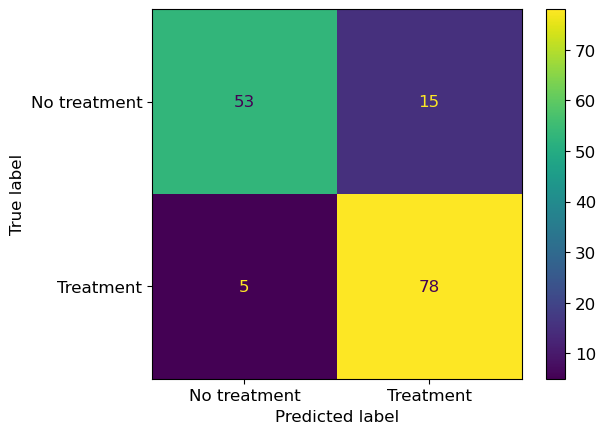

In [63]:
# Produce a confusion matrix for the final evaluation metrics
cm_us = confusion_matrix(y_test_us, final_predictions_us)
plt.rc('font', size=12)
ConfusionMatrixDisplay(cm_us, display_labels=["No treatment", "Treatment"]).plot()

In [64]:
# Display the final evaluation metrics
print(
   classification_report(
        y_test_us,
        final_predictions_us,
        target_names=["No treatment", "Treatment"]
    )
)

              precision    recall  f1-score   support

No treatment       0.91      0.78      0.84        68
   Treatment       0.84      0.94      0.89        83

    accuracy                           0.87       151
   macro avg       0.88      0.86      0.86       151
weighted avg       0.87      0.87      0.87       151



#### Non-US

In [65]:
# Fit the final model onto all of the training data
final_model_other.fit(X_train_other, y_train_other)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneH...
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['self_employed',
                                                                          'family_history',
                                                                          'remote_work',
                                                                          'tech_company',
                                                                          'obs_consequence'])])),
                                       ('rfecv',
                                        RFECV(cv=2,
                                              estimator=LogisticRegression(max_iter=1000),
                                              min_features_to_select=31,
                                              scoring='f1', step=4)),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1.0, 10, 100],
                         'svc__gamma': [0.1, 1.0, 10, 100]},
             return_train_score=True, scoring='f1')

In [66]:
# Obtain the training score of the final model
final_train_score_other = final_model_other.score(X_train_other, y_train_other)
print("Training score of the final model:", final_train_score_other)

# Obtain the test score of the final model
final_test_score_other = final_model_other.score(X_test_other, y_test_other)
print("Test score of the final model:", final_test_score_other)

Training score of the final model: 0.8171021377672208
Test score of the final model: 0.792079207920792


In [67]:
# Make predictions on the test set
final_predictions_other = final_model_other.predict(X_test_other)

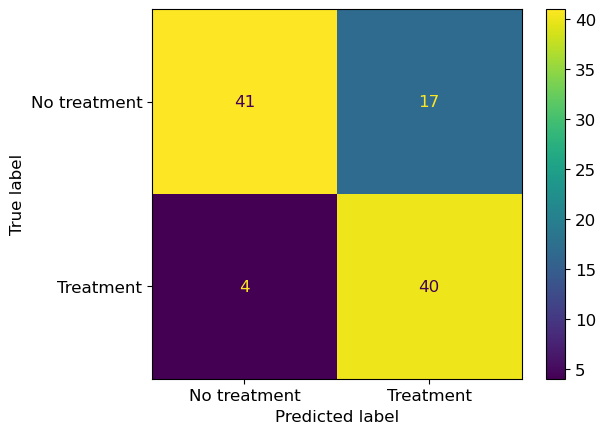

In [68]:
# Produce a confusion matrix for the final evaluation metrics
cm_other = confusion_matrix(y_test_other, final_predictions_other)
plt.rc('font', size=12)
ConfusionMatrixDisplay(cm_other, display_labels=["No treatment", "Treatment"]).plot()

In [69]:
# Display the final evaluation metrics
print(
   classification_report(
        y_test_other,
        final_predictions_other,
        target_names=["No treatment", "Treatment"]
    )
)

              precision    recall  f1-score   support

No treatment       0.91      0.71      0.80        58
   Treatment       0.70      0.91      0.79        44

    accuracy                           0.79       102
   macro avg       0.81      0.81      0.79       102
weighted avg       0.82      0.79      0.79       102



### Fairness Optimization

#### US

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'count'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>]], dtype=object)

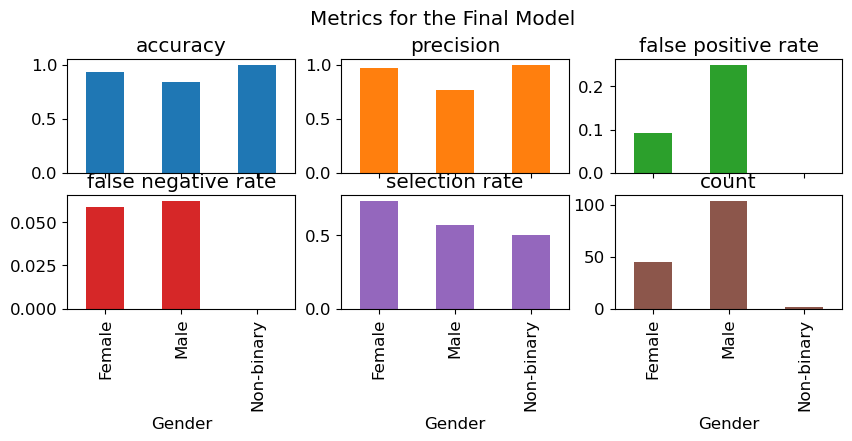

In [70]:
# Examine model fairness
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count
}
metric_frame = MetricFrame(
    metrics = metrics, y_true = y_test_us, y_pred = final_predictions_us, sensitive_features = A_test_us
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[10, 5],
    title="Metrics for the Final Model",
)

In [71]:
# Calculate demographic parity and equalized odds ratios
dpr_us = demographic_parity_ratio(y_test_us, final_predictions_us, sensitive_features = A_test_us)
eqo_us = equalized_odds_ratio(y_test_us, final_predictions_us, sensitive_features = A_test_us)
print(f'Value of demographic parity ratio: {round(dpr_us, 4)}')
print(f'Value of equal odds ratio: {round(eqo_us, 4)}')

Value of demographic parity ratio: 0.6818
Value of equal odds ratio: 0.0


In [72]:
# Initiate an optimizer to optimize the false negative rate parity between genders
optimizer_us = ThresholdOptimizer(
    estimator = final_model_us,
    constraints = "false_negative_rate_parity", 
    predict_method = "predict_proba",
    prefit = False
)

# Fit the optimizer to the training data
optimizer_us.fit(X_train_us, y_train_us, sensitive_features = A_train_us)

# Make predictions using optimized model
final_prediction_us_fair = optimizer_us.predict(X_test_us, sensitive_features = A_test_us)

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'count'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>]], dtype=object)

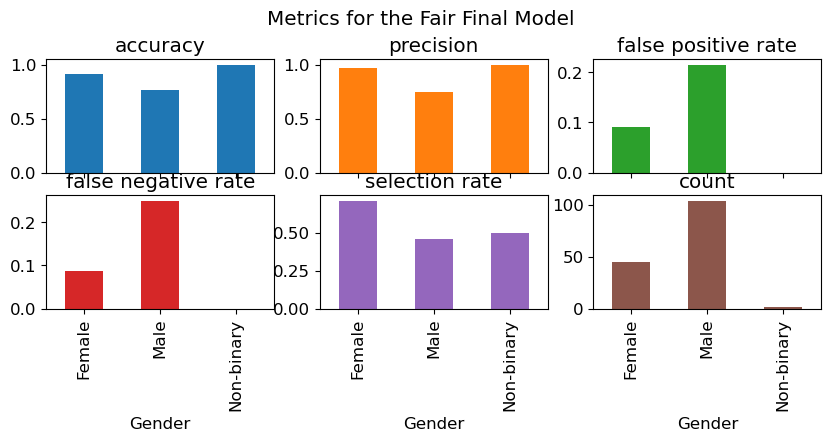

In [73]:
# Re-evaluate fairness of model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count
}
metric_frame = MetricFrame(
    metrics = metrics, y_true = y_test_us, y_pred = final_prediction_us_fair, sensitive_features = A_test_us
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[10, 5],
    title="Metrics for the Fair Final Model"
)

In [74]:
# Calculate demographic parity and equalized odds ratios
dpr_fair_us = demographic_parity_ratio(y_test_us, final_prediction_us_fair, sensitive_features = A_test_us)
eqo_fair_us = equalized_odds_ratio(y_test_us, final_prediction_us_fair, sensitive_features = A_test_us)
print(f'Value of demographic parity ratio (after post-processing): {round(dpr_fair_us, 4)}')
print(f'Value of equal odds ratio (after post-processing): {round(eqo_fair_us, 4)}')

Value of demographic parity ratio (after post-processing): 0.649
Value of equal odds ratio (after post-processing): 0.0


#### Non-US

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'count'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>]], dtype=object)

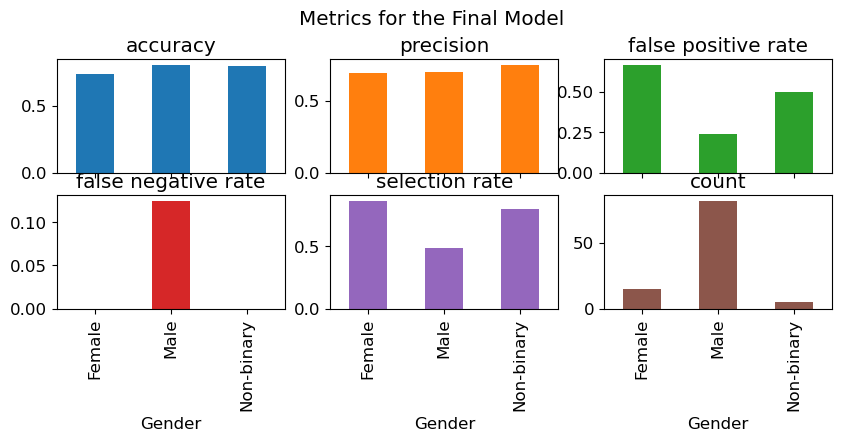

In [75]:
# Examine model fairness
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count
}
metric_frame = MetricFrame(
    metrics = metrics, y_true = y_test_other, y_pred = final_predictions_other, sensitive_features = A_test_other
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[10, 5],
    title="Metrics for the Final Model"
)

In [76]:
# Calculate demographic parity and equalized odds ratios
dpr_other = demographic_parity_ratio(y_test_other, final_predictions_other, sensitive_features = A_test_other)
eqo_other = equalized_odds_ratio(y_test_other, final_predictions_other, sensitive_features = A_test_other)
print(f'Value of demographic parity ratio: {round(dpr_other, 4)}')
print(f'Value of equal odds ratio: {round(eqo_other, 4)}')

Value of demographic parity ratio: 0.5629
Value of equal odds ratio: 0.36


In [77]:
# Initiate an optimizer to optimize the false negative rate parity between genders
optimizer_other = ThresholdOptimizer(
    estimator = final_model_other,
    constraints = "false_negative_rate_parity", 
    predict_method = "predict_proba",
    prefit = False
)

# Fit the optimizer to the training data
optimizer_other.fit(X_train_other, y_train_other, sensitive_features = A_train_other)

# Make predictions using optimized model
final_predictions_other_fair = optimizer_other.predict(X_test_other, sensitive_features = A_test_other)

array([[<Axes: title={'center': 'accuracy'}, xlabel='Gender'>,
        <Axes: title={'center': 'precision'}, xlabel='Gender'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='Gender'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'selection rate'}, xlabel='Gender'>,
        <Axes: title={'center': 'count'}, xlabel='Gender'>],
       [<Axes: xlabel='Gender'>, <Axes: xlabel='Gender'>,
        <Axes: xlabel='Gender'>]], dtype=object)

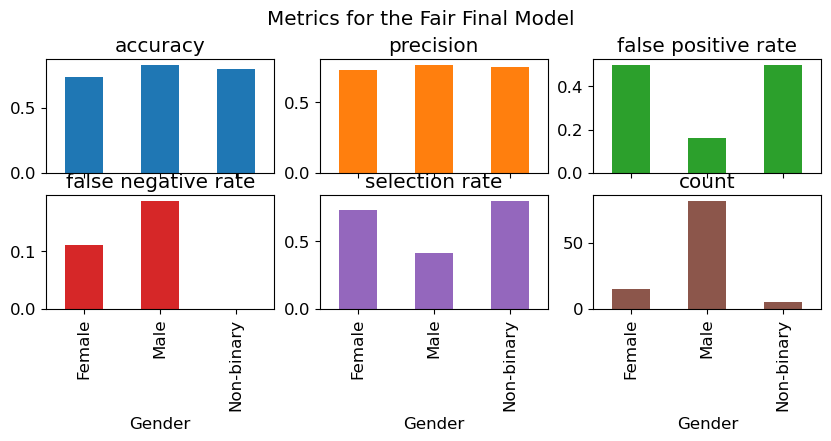

In [78]:
# Re-evaluate fairness of model
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count
}
metric_frame = MetricFrame(
    metrics = metrics, y_true = y_test_other, y_pred = final_predictions_other_fair, sensitive_features = A_test_other
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[10, 5],
    title="Metrics for the Fair Final Model"
)

In [79]:
# Calculate demographic parity and equalized odds ratios
dpr_fair_other = demographic_parity_ratio(y_test_other, final_predictions_other_fair, sensitive_features = A_test_other)
eqo_fair_other = equalized_odds_ratio(y_test_other, final_predictions_other_fair, sensitive_features = A_test_other)
print(f'Value of demographic parity ratio (after post-processing): {round(dpr_fair_other, 4)}')
print(f'Value of equal odds ratio (after post-processing): {round(eqo_fair_other, 4)}')

Value of demographic parity ratio (after post-processing): 0.5183
Value of equal odds ratio (after post-processing): 0.32
